# Description

This notebook is an extension of the original Project 2 Juptyer Notebook with contains all of the data inspection, cleaning, preparation and initial model creation and evaluation.

For the full description and explanation of our dataset, please see the original Juptyer Notebook.

A need to further refine our approach to building our predictive model was necessary and thus we created a secondary notebook in order to clearly show our model progression after creating a balanaced dataset.

In [ ]:
#Necessary Imports for Data Cleaning and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
job_df = pd.read_csv('/content/drive/Shareddrives/MATH 3439 Work/Project 2/cleaned_fake_job_postings.csv')
job_df.head()

,job_id,title,location,department,Standardized_Department,Standardized_Department_Administrative,Standardized_Department_Business Consulting,Standardized_Department_Creative & Design,Standardized_Department_Customer Service,Standardized_Department_Education & Training,...,Standardized_Industry_Marketing,Standardized_Industry_Media,Standardized_Industry_Nonprofit,Standardized_Industry_Not Provided,Standardized_Industry_Real Estate,Standardized_Industry_Retail,Standardized_Industry_Security,Standardized_Industry_Transportation,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,Marketing,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Not Provided,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Not Provided,Not Provided,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Provided,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Sales,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",Not Provided,Not Provided,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Health Care Provider,0


Original confusion matrix showed that our model was predicting all job to be geniune, despite ~5% of the dataset being fraudulent.

Therefore, next steps are to create a balanced dataset and re-preform analysis. The general steps for this is will be as follows:
1. split the data to have an equal number of real and fraudulent listings
2. re-train data with logistic regression with warm start. This will allow the model to reuse the solution from the previous training run, with the next set of geniune job listings.


## Data Inspection

### Changing One-Hot Encoding of `Department` and `Industry` columns

While building version two of our, we found that some of our input columns were highly or perfectly correlated with each other. One reason for this could be dummy variable traps or one hot encoding without dropping a reference category.

Therefore, the following code is ensuring that we properly dropped a reference column.

In [ ]:
#Industry Column
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder with drop='first' to remove the reference category
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'Standardized_Industry' column
encoded_array = encoder.fit_transform(job_df[['Standardized_Industry']])

# Convert the array into a DataFrame with named columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Standardized_Industry']))

# Concatenate the original DataFrame with the encoded DataFrame
job_df = pd.concat([job_df, encoded_df], axis=1)

# Optionally, drop the original categorical column
job_df.drop(columns=['Standardized_Industry'], inplace=True)


In [ ]:
#Department Column

# Fit and transform the 'Standardized_Industry' column
encoded_array = encoder.fit_transform(job_df[['Standardized_Department']])

# Convert the array into a DataFrame with named columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Standardized_Department']))

# Concatenate the original DataFrame with the encoded DataFrame
job_df = pd.concat([job_df, encoded_df], axis=1)

# Optionally, drop the original categorical column
job_df.drop(columns=['Standardized_Department'], inplace=True)

In [ ]:
job_df = job_df.loc[:, ~job_df.columns.duplicated()]

# Initial Model Construction

## Creating Balanced Dataset

In [ ]:
#Split the dataset into fake and real job postings
fake_jobs = job_df[job_df['fraudulent'] == 1]
real_jobs = job_df[job_df['fraudulent'] == 0]

#Determine the number of samples to keep for each category
min_count = min(len(fake_jobs), len(real_jobs))

#Randomly sample the same number of fake and real job postings
fake_jobs_sampled = fake_jobs.sample(n=min_count, random_state=42)
real_jobs_sampled = real_jobs.sample(n=min_count, random_state=42)

#Concatenate the sampled data back into a single DataFrame
balanced_df = pd.concat([fake_jobs_sampled, real_jobs_sampled], axis=0)

In [ ]:
balanced_df.shape

(1732, 71)

## Splitting data into Train, Validation, and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(balanced_df, train_size=0.7, test_size=0.3)

test_df, val_df = train_test_split(test_df, train_size=0.5, test_size=0.5)

## Model Training & Evaluation

### Logistic Regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Instantiate Model
logr = LogisticRegression(warm_start=True, max_iter=1000, solver='saga')

# Get data from TRAINING SET of BALANCED DF
feature_columns = train_df.drop(columns=['fraudulent', 'salary_range', 'job_id']).select_dtypes(include=['int64', 'float64']).columns
X_train = train_df[feature_columns]
y_train = train_df['fraudulent']

# Get data from VALIDATION SET of BALANCED DF
X_val = val_df[feature_columns]
y_val = val_df['fraudulent']

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Fit Model
logr.fit(X_train, y_train)

# Print feature names with coefficients
coefficients = logr.coef_[0]  # logr.coef_ returns a 2D array, so we extract the first row
feature_importance = list(zip(feature_columns, coefficients))

# Display the results
for feature, coef in feature_importance:
    print(f"{feature}: {coef:.4f}")

Standardized_Department_Administrative: 0.0000
Standardized_Department_Business Consulting: -0.0000
Standardized_Department_Creative & Design: -0.0000
Standardized_Department_Customer Service: 0.0000
Standardized_Department_Education & Training: 0.0000
Standardized_Department_Engineering: 0.0000
Standardized_Department_Finance & Accounting: -0.0000
Standardized_Department_Government & Public Sector: 0.0000
Standardized_Department_Healthcare: 0.0000
Standardized_Department_Hospitality & Food Services: 0.0000
Standardized_Department_Human Resources: 0.0000
Standardized_Department_IT: -0.0000
Standardized_Department_Legal & Compliance: 0.0000
Standardized_Department_Logistics & Supply Chain: -0.0000
Standardized_Department_Manufacturing & Production: -0.0000
Standardized_Department_Marketing: -0.0000
Standardized_Department_Media & Communications: -0.0000
Standardized_Department_Not Provided: 0.0000
Standardized_Department_Operations: -0.0000
Standardized_Department_Product Management & D

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Feature Importance

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Instantiate Model
logr = LogisticRegression(warm_start=True, max_iter=5000, solver='saga')

# Get data from TRAINING SET of BALANCED DF
feature_columns = train_df.drop(
    columns=['fraudulent', 'salary_range', 'job_id'] +
             train_df.filter(like='Standardized_Department').columns.tolist()
).select_dtypes(include=['int64', 'float64']).columns
X_train = train_df[feature_columns]
y_train = train_df['fraudulent']

# Get data from VALIDATION SET of BALANCED DF
X_val = val_df[feature_columns]
y_val = val_df['fraudulent']

# Impute missing values using the mean
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Fit Model
logr.fit(X_train, y_train)

# Now you should be able to access the coefficients
# Ensure feature_columns and logr.coef_[0] have the same length
feature_importance = pd.DataFrame({'Feature': feature_columns, 'Coefficient': logr.coef_[0][:len(feature_columns)]})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print(feature_importance)

                                         Feature   Coefficient
25            Standardized_Industry_Not Provided  2.711840e-09
17                 Standardized_Industry_Finance  1.036923e-09
2                                  telecommuting  3.641047e-10
26             Standardized_Industry_Real Estate  2.961579e-10
8               Standardized_Industry_Automotive  2.965179e-11
7              Standardized_Industry_Agriculture  2.960014e-11
28                Standardized_Industry_Security  2.959393e-11
14             Standardized_Industry_Engineering  7.987431e-14
11          Standardized_Industry_Consumer Goods  6.015947e-14
16  Standardized_Industry_Environmental Services  1.452319e-14
15           Standardized_Industry_Entertainment  0.000000e+00
18              Standardized_Industry_Government  0.000000e+00
23                   Standardized_Industry_Media -2.940266e-11
29          Standardized_Industry_Transportation -5.905257e-11
27                  Standardized_Industry_Retail -5.905

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score

# Predict class labels
y_val_pred = logr.predict(X_val)

# Compute accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print Results
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.4846


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

# ... (rest of your imports)

# Assuming 'logr' is your trained model and 'feature_columns' is defined
# during training as:
feature_columns = train_df.drop(
     columns=['fraudulent', 'salary_range', 'job_id'] +
              train_df.filter(like='Standardized_Department').columns.tolist()
 ).select_dtypes(include=['int64', 'float64']).columns

# Get data from VALIDATION SET of BALANCED DF, using the SAME feature_columns
X_val = val_df[feature_columns]  # Ensure consistency with training data
y_val = val_df['fraudulent']

# Impute missing values using the SAME imputer fitted on training data
# Assuming you have already fitted an imputer: imputer = SimpleImputer(strategy='mean')
X_val = imputer.transform(X_val)  # Use the same imputer

# Predict class labels
y_val_pred = logr.predict(X_val)

# Compute accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print Results
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.4846


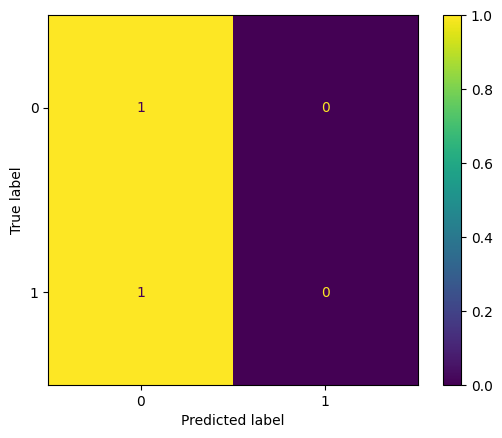

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

# Assuming 'feature_columns' is defined as in your training code
X_test = test_df[feature_columns]  # Select the same features used for training
# Impute missing values using the mean (using the imputer fitted on training data)
X_test = imputer.transform(X_test)

# Get the true labels for the test set
y_test = test_df['fraudulent']  # Assuming 'fraudulent' is your target column

y_pred = logr.predict(X_test)  # Predict on the transformed test data

ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred, normalize='true')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


def evaluate_top_features(model, train_df, val_df, coef_threshold=0.1):
    """
    Fits logistic regression models for individual features and all features,
    evaluates their accuracy on the validation set, and prints the results.

    Parameters:
    - model: Trained logistic regression model
    - train_df: Training dataset (DataFrame)
    - val_df: Validation dataset (DataFrame)
    - coef_threshold: Minimum absolute coefficient value to include a feature
    """

    # Prepare training and validation data
    X_train_df = train_df.drop(
        columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])  # Keep as DataFrame
    y_train = train_df['fraudulent']

    X_val_df = val_df.drop(
        columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])  # Keep as DataFrame
    y_val = val_df['fraudulent']

    # Create and Fit an Imputer
    # Get numeric columns explicitly to avoid 'salary_diff'
    numeric_cols = X_train_df.select_dtypes(include=np.number).columns
    imputer = SimpleImputer(strategy='mean')
    X_train_df[numeric_cols] = imputer.fit_transform(X_train_df[numeric_cols])
    X_val_df[numeric_cols] = imputer.transform(X_val_df[numeric_cols])

    # Fit the model on the full training set to get coefficients
    model.fit(X_train_df, y_train)

    # Extract coefficients and feature names from the original DataFrame
    coef_df = pd.DataFrame({
        'Feature': X_train_df.columns,
        'Coefficient': model.coef_.flatten()
    })

    # Filter features above the coefficient threshold
    significant_features = coef_df[coef_df['Coefficient'].abs() >= coef_threshold]

    # Sort coefficients in descending order
    significant_features = significant_features.sort_values(by="Coefficient", ascending=False)

    print(f"\nFeatures with coefficients >= {coef_threshold}:\n", significant_features)

    # Track accuracy scores
    accuracy_scores = {}

    # Iterate over selected features and fit a logistic regression model for each
    for feature in significant_features['Feature']:
        # Extracting the feature from the imputed DataFrames
        X_train_subset = X_train_df[[feature]]
        X_val_subset = X_val_df[[feature]]

        temp_model = LogisticRegression()
        temp_model.fit(X_train_subset, y_train)

        # Predict on validation data
        y_val_pred = temp_model.predict(X_val_subset)
        accuracy = accuracy_score(y_val, y_val_pred)
        accuracy_scores[feature] = accuracy

        print(f"Feature: {feature} | Validation Accuracy: {accuracy:.4f}")

    # --- Additional code to evaluate overall model accuracy ---

    # Predict on validation data using the original model (with all features)
    y_val_pred_all_features = model.predict(X_val_df)  # Use X_val_df here
    accuracy_all_features = accuracy_score(y_val, y_val_pred_all_features)

    print(f"\nOverall Model Accuracy (with all features): {accuracy_all_features:.4f}")

    # Sort features by accuracy
    sorted_features = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)

    # Print sorted accuracy results
    print("\nSorted Accuracy Scores:")
    for feature, acc in sorted_features:
        print(f"Feature: {feature} | Accuracy: {acc:.4f}")

#### Coefficient Thresholds (0.1, 0.3, 0.05)

In [ ]:
#0.1 Threshold
logr = LogisticRegression(warm_start=True, max_iter=10000)
evaluate_top_features(logr, train_df, val_df)


Features with coefficients >= 0.1:
                                  Feature  Coefficient
26     Standardized_Industry_Real Estate     1.473967
17         Standardized_Industry_Finance     1.203725
23           Standardized_Industry_Media     0.636019
8       Standardized_Industry_Automotive     0.620135
25    Standardized_Industry_Not Provided     0.597051
27          Standardized_Industry_Retail     0.420786
22       Standardized_Industry_Marketing     0.408579
28        Standardized_Industry_Security     0.377499
7      Standardized_Industry_Agriculture     0.350726
29  Standardized_Industry_Transportation     0.343076
2                          telecommuting     0.276370
14     Standardized_Industry_Engineering     0.112525
11  Standardized_Industry_Consumer Goods     0.101081
21             Standardized_Industry_Law    -0.181690
4                          has_questions    -0.286302
24       Standardized_Industry_Nonprofit    -0.379553
19     Standardized_Industry_Health Care    -

In [ ]:
#0.3 Threshold
logr = LogisticRegression(warm_start=True, max_iter=10000)
evaluate_top_features(logr, train_df, val_df, coef_threshold=0.3)


Features with coefficients >= 0.3:
                                  Feature  Coefficient
26     Standardized_Industry_Real Estate     1.473967
17         Standardized_Industry_Finance     1.203725
23           Standardized_Industry_Media     0.636019
8       Standardized_Industry_Automotive     0.620135
25    Standardized_Industry_Not Provided     0.597051
27          Standardized_Industry_Retail     0.420786
22       Standardized_Industry_Marketing     0.408579
28        Standardized_Industry_Security     0.377499
7      Standardized_Industry_Agriculture     0.350726
29  Standardized_Industry_Transportation     0.343076
24       Standardized_Industry_Nonprofit    -0.379553
19     Standardized_Industry_Health Care    -0.424280
9     Standardized_Industry_Construction    -0.519448
10      Standardized_Industry_Consulting    -0.908950
13     Standardized_Industry_Electronics    -1.843153
12       Standardized_Industry_Education    -1.853217
3                       has_company_logo    -

In [ ]:
#0.05 Threshold
logr = LogisticRegression(warm_start=True, max_iter=10000)
evaluate_top_features(logr, train_df, val_df, coef_threshold=0.05)


Features with coefficients >= 0.05:
                                  Feature  Coefficient
26     Standardized_Industry_Real Estate     1.473967
17         Standardized_Industry_Finance     1.203725
23           Standardized_Industry_Media     0.636019
8       Standardized_Industry_Automotive     0.620135
25    Standardized_Industry_Not Provided     0.597051
27          Standardized_Industry_Retail     0.420786
22       Standardized_Industry_Marketing     0.408579
28        Standardized_Industry_Security     0.377499
7      Standardized_Industry_Agriculture     0.350726
29  Standardized_Industry_Transportation     0.343076
2                          telecommuting     0.276370
14     Standardized_Industry_Engineering     0.112525
11  Standardized_Industry_Consumer Goods     0.101081
6                      education_encoded     0.052238
21             Standardized_Industry_Law    -0.181690
4                          has_questions    -0.286302
24       Standardized_Industry_Nonprofit    

### Calculating Variance Inflation Factor

Given that many of our features had very similar to exact validation accurcy scores, we wanted to check multicollinearity of if several of our input columns were correlated with one another

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    """
    Computes Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing only the independent variables

    Returns:
    - DataFrame with features and their VIF scores
    """
    # Select only numeric features
    numeric_df = df.select_dtypes(include=['int64', 'float64']).replace([np.inf, -np.inf], np.nan).dropna()

    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

    return vif_data.sort_values(by="VIF", ascending=False)

In [ ]:
X_train_numeric = balanced_df.drop(columns=['fraudulent'])  # Drop target variable
vif_scores = calculate_vif(X_train_numeric)

# Display VIF scores
print(vif_scores)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                                              Feature           VIF
56               Standardized_Industry_Transportation           inf
38               Standardized_Industry_Consumer Goods           inf
25                      Standardized_Department_Sales           inf
53                  Standardized_Industry_Real Estate           inf
55                     Standardized_Industry_Security           inf
1              Standardized_Department_Administrative           inf
54                       Standardized_Industry_Retail           inf
35                   Standardized_Industry_Automotive           inf
36                 Standardized_Industry_Construction           inf
37                   Standardized_Industry_Consulting           inf
39                    Standardized_Industry_Education           inf
22  Standardized_Department_Quality Assurance & Te...           inf
40                  Standardized_Industry_Electronics           inf
44                      Standardized_Industry_Fi

## Investigating false positives/negatives

Utilizing skelearn's ability to calculate true positive, negative, and prevision rates to get a better understanding of how our model is preforming before moving towards implementing additional strategies.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score

# Assuming you already trained your model and have validation data
y_pred = logr.predict(X_val)  # Model predictions on validation set
y_true = y_val  # Actual labels from validation set

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate (Recall or Sensitivity)
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
precision = precision_score(y_true, y_pred)  # Precision

# Print results
print("Accuracy Metrics for Model with Dropped Department")
print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Precision: {precision:.4f}")


Accuracy Metrics for Model with Dropped Department
True Positive Rate (TPR / Recall): 0.5970
True Negative Rate (TNR / Specificity): 0.8016
False Positive Rate (FPR): 0.1984
False Negative Rate (FNR): 0.4030
Precision: 0.7619


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


##Principle Component Analysis

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

# Drop unnecessary columns from train and validation datasets
X_train_df = train_df.drop(
    columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])
y_train = train_df['fraudulent']

X_val_df = val_df.drop(
        columns=['fraudulent', 'salary_range', 'job_id'] +
                 train_df.filter(like='Standardized_Department').columns.tolist()
    ).select_dtypes(include=['int64', 'float64'])
y_val = val_df['fraudulent']

# # Define feature columns after dropping unnecessary ones
# feature_columns = train_df.drop(columns=['fraudulent', 'salary_range', 'job_id']).select_dtypes(
#     include=['int64', 'float64']
# ).columns

# Standardize the features
scaler = StandardScaler()

# Impute missing values using SimpleImputer before scaling
imputer = SimpleImputer(strategy='mean')  # or other strategy
scaled_train_features = scaler.fit_transform(imputer.fit_transform(train_df[feature_columns]))

# Apply PCA (keep enough components to explain 95% of variance)
pca = PCA(n_components=0.95)
pca_train_features = pca.fit_transform(scaled_train_features)

# Convert PCA result back to a DataFrame
pca_train_df = pd.DataFrame(data=pca_train_features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Train Logistic Regression model
logr = LogisticRegression()
logr.fit(pca_train_df, train_df['fraudulent'])  # Assuming 'fraudulent' is the target column

# Transform validation dataset using the same preprocessing
# Impute missing values in validation set before scaling
scaled_val_features = scaler.transform(imputer.transform(val_df[feature_columns]))
pca_val_features = pca.transform(scaled_val_features)

# Predict class labels on validation set
y_val_pred = logr.predict(pca_val_features)

# Compute validation accuracy
val_accuracy = accuracy_score(val_df['fraudulent'], y_val_pred)

# Compute confusion matrix components
tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], y_val_pred).ravel()

# Calculate accuracy metrics
tpr = tp / (tp + fn)  # True Positive Rate (Recall)
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
precision = precision_score(val_df['fraudulent'], y_val_pred)

# Print results
print("Accuracy Metrics w/ PCA (Dropped Industry)")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy Metrics w/ PCA (Dropped Industry)
Validation Accuracy: 0.6462
True Positive Rate (TPR / Recall): 0.5970
True Negative Rate (TNR / Specificity): 0.6984
False Positive Rate (FPR): 0.3016
False Negative Rate (FNR): 0.4030
Precision: 0.6780


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.impute import SimpleImputer
import pandas as pd

def pca_logistic_regression(train_df, val_df, feature_columns):
    """
    Applies PCA to the specified features, trains a logistic regression model,
    and evaluates it on the validation set.

    Args:
        train_df (pd.DataFrame): Training dataset.
        val_df (pd.DataFrame): Validation dataset.
        feature_columns (list): List of feature column names.

    Returns:
        dict: Dictionary containing accuracy metrics.
    """

    # Create an imputer to handle missing values
    imputer = SimpleImputer(strategy='mean')  # or other strategies like 'median', 'most_frequent'

    # Fit and transform the imputer on your training data
    train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df[feature_columns]), columns=feature_columns)

    # Standardize the features using the imputed data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(train_df_imputed)

    # Apply PCA
    pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of variance
    pca_features = pca.fit_transform(scaled_features)

    # Convert PCA result back to a DataFrame
    pca_df = pd.DataFrame(data=pca_features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    # Train a logistic regression model on the PCA-transformed data
    model = LogisticRegression()
    model.fit(pca_df, train_df['fraudulent'])  # Assuming 'fraudulent' is the target column

    # Transform validation dataset using the same preprocessing
    # Impute missing values in validation set before scaling
    val_df_imputed = pd.DataFrame(imputer.transform(val_df[feature_columns]), columns=feature_columns)
    scaled_val_features = scaler.transform(val_df_imputed)
    pca_val_features = pca.transform(scaled_val_features)

    # Make predictions
    val_preds = model.predict(pca_val_features)

    # Calculate accuracy metrics
    accuracy = accuracy_score(val_df['fraudulent'], val_preds)
    precision = precision_score(val_df['fraudulent'], val_preds)
    recall = recall_score(val_df['fraudulent'], val_preds)
    tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], val_preds).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate (Recall)
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate

    # Print the explained variance ratio for each principal component
    print("Explained variance ratio for each principal component:")
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"Principal Component {i+1}: {variance:.4f}")

    # Print the feature column names and their contributions to each principal component
    loadings_df = pd.DataFrame(pca.components_, columns=feature_columns)
    print("\nFeature Contributions to Principal Components:")
    for i in range(loadings_df.shape[0]):
        print(f"\nPrincipal Component {i+1}:")
        for j in range(len(feature_columns)):
            print(f"  {feature_columns[j]}: {loadings_df.iloc[i, j]:.4f}")

    # Return the metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'tpr': tpr,
        'tnr': tnr,
        'fpr': fpr,
        'fnr': fnr
    }


In [ ]:
metrics = pca_logistic_regression(train_df, val_df, feature_columns)
print(metrics)

Explained variance ratio for each principal component:
Principal Component 1: 0.0870
Principal Component 2: 0.0513
Principal Component 3: 0.0467
Principal Component 4: 0.0431
Principal Component 5: 0.0397
Principal Component 6: 0.0386
Principal Component 7: 0.0374
Principal Component 8: 0.0370
Principal Component 9: 0.0365
Principal Component 10: 0.0363
Principal Component 11: 0.0361
Principal Component 12: 0.0360
Principal Component 13: 0.0360
Principal Component 14: 0.0359
Principal Component 15: 0.0359
Principal Component 16: 0.0358
Principal Component 17: 0.0358
Principal Component 18: 0.0358
Principal Component 19: 0.0358
Principal Component 20: 0.0358
Principal Component 21: 0.0351
Principal Component 22: 0.0329
Principal Component 23: 0.0306
Principal Component 24: 0.0264
Principal Component 25: 0.0248

Feature Contributions to Principal Components:

Principal Component 1:
  salary_diff: -0.0057
  job_desc_length: -0.0535
  telecommuting: 0.0746
  has_company_logo: -0.3513
  has

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Now that we've run PCA, we can confirm if we've successfully reduced dimensionality and work towards identifying the optimal number of principal components to keep for further testing. By running `len(feature_columns)`, we see that our model is utilizing 30 out of our 71 columns.

However, from our above PCA, we were getting 24 Principal Components, which doesn't reduce dimensionality very much. This suggests that the features we've kept contain a lot of useful information and/or are still highly dependent on each other.

Furthermore, by looking at the graph below, we see that the optimal number of principal components is 26. This is not the full story however. In the below function definition `test_pca_with_different_components`, we see that accuracy is highest when using 23 principal components, which does reduce our dimensionality (even if only slightly).  



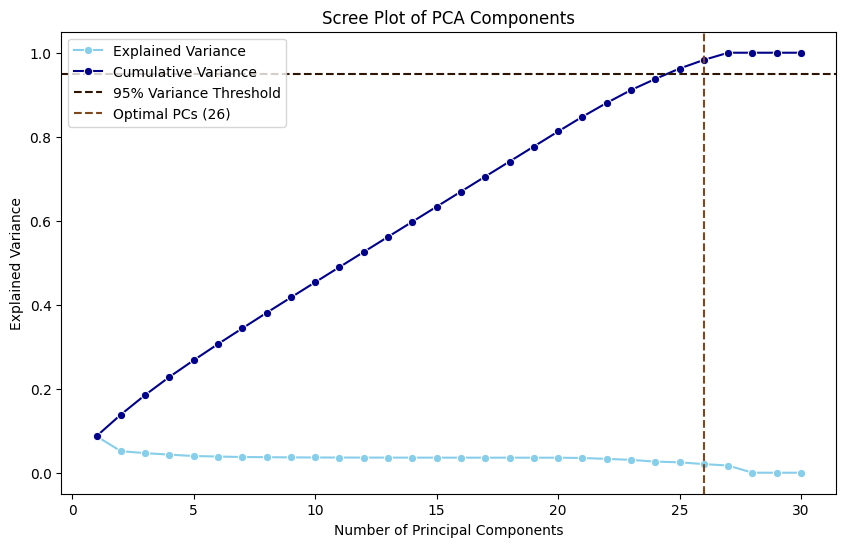

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with column means
imputed_features = imputer.fit_transform(train_df[feature_columns])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

# Apply PCA
pca = PCA()
pca.fit(scaled_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot Scree Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(explained_variance) + 1), y=explained_variance, marker='o', color='skyblue', label='Explained Variance')
sns.lineplot(x=range(1, len(explained_variance) + 1), y=cumulative_variance, marker='o', color='darkblue', label='Cumulative Variance')

# Add reference lines
plt.axhline(y=0.95, color='#2e1503', linestyle='dashed', label="95% Variance Threshold")  # Red dashed line at 95%
plt.axvline(x=26, color='#80471c', linestyle='dashed', label="Optimal PCs (26)")  # Green dashed line at 26 PCs

# Labels and Title
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.title("Scree Plot of PCA Components")
plt.legend()
plt.figure(facecolor=(246/255, 246/255, 246/255))

# Show plot
plt.show()

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.impute import SimpleImputer

def test_pca_with_different_components(train_df, val_df, feature_columns, n_components_list):
    """
    Tests different PCA components and evaluates model performance.

    Args:
        train_df (pd.DataFrame): Training dataset.
        val_df (pd.DataFrame): Validation dataset.
        feature_columns (list): List of feature column names.
        n_components_list (list): List of n_components values to test.

    Returns:
        pd.DataFrame: DataFrame containing performance metrics for each n_components.
    """
    # Create an imputer to handle missing values
    imputer = SimpleImputer(strategy='mean')

    # Impute and scale the training data
    train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df[feature_columns]), columns=feature_columns)
    scaler = StandardScaler()
    scaled_train_features = scaler.fit_transform(train_df_imputed)

    # List to store performance metrics
    metrics_list = []

    for n_components in n_components_list:
        # Apply PCA
        pca = PCA(n_components=n_components)
        pca_features = pca.fit_transform(scaled_train_features)

        # Train a logistic regression model
        model = LogisticRegression()
        model.fit(pca_features, train_df['fraudulent'])

        # Impute and scale the validation data
        val_df_imputed = pd.DataFrame(imputer.transform(val_df[feature_columns]), columns=feature_columns)
        scaled_val_features = scaler.transform(val_df_imputed)
        pca_val_features = pca.transform(scaled_val_features)

        # Make predictions
        val_preds = model.predict(pca_val_features)

        # Calculate metrics
        accuracy = accuracy_score(val_df['fraudulent'], val_preds)
        precision = precision_score(val_df['fraudulent'], val_preds)
        tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], val_preds).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate (Recall)
        tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
        fpr = fp / (fp + tn)  # False Positive Rate
        fnr = fn / (fn + tp)  # False Negative Rate

        # Append the metrics to the list
        metrics_list.append({
            "n_components": n_components,
            "accuracy": accuracy,
            "precision": precision,
            "tpr": tpr,
            "tnr": tnr,
            "fpr": fpr,
            "fnr": fnr
        })

    # Create a DataFrame from the list of metrics
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df

# Define the range of n_components to test
n_components_list = range(1, 30)  # Adjust this range as needed

# Run the testing function
performance_metrics = test_pca_with_different_components(train_df, val_df, feature_columns, n_components_list)

# Print the performance metrics
print(performance_metrics)


    n_components  accuracy  precision       tpr       tnr       fpr       fnr
0              1  0.634615   0.669565  0.574627  0.698413  0.301587  0.425373
1              2  0.661538   0.671642  0.671642  0.650794  0.349206  0.328358
2              3  0.665385   0.674074  0.679104  0.650794  0.349206  0.320896
3              4  0.657692   0.666667  0.671642  0.642857  0.357143  0.328358
4              5  0.653846   0.664179  0.664179  0.642857  0.357143  0.335821
5              6  0.653846   0.666667  0.656716  0.650794  0.349206  0.343284
6              7  0.653846   0.666667  0.656716  0.650794  0.349206  0.343284
7              8  0.653846   0.664179  0.664179  0.642857  0.357143  0.335821
8              9  0.657692   0.666667  0.671642  0.642857  0.357143  0.328358
9             10  0.653846   0.664179  0.664179  0.642857  0.357143  0.335821
10            11  0.653846   0.664179  0.664179  0.642857  0.357143  0.335821
11            12  0.653846   0.664179  0.664179  0.642857  0.357

## Utilizing PCA with 23 Principal Components

In [ ]:
# Transform the training data
pca = PCA(n_components=23)
pca_train_features = pca.fit_transform(scaled_train_features)

# Transform the validation data
pca_val_features = pca.transform(scaled_val_features)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# Train your logistic regression model
logr = LogisticRegression()
logr.fit(pca_train_features, train_df['fraudulent'])

# Make predictions on the validation set
val_preds = logr.predict(pca_val_features)

# Calculate accuracy
accuracy = accuracy_score(val_df['fraudulent'], val_preds)

# Calculate precision
precision = precision_score(val_df['fraudulent'], val_preds)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(val_df['fraudulent'], val_preds).ravel()

# Calculate TNR, TPR, FPR, and FNR
tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
tpr = tp / (tp + fn)  # True Positive Rate (Recall)
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"TNR: {tnr}")
print(f"TPR: {tpr}")
print(f"FPR: {fpr}")
print(f"FNR: {fnr}")


Accuracy: 0.676923076923077
Precision: 0.6984126984126984
TNR: 0.6984126984126984
TPR: 0.6567164179104478
FPR: 0.30158730158730157
FNR: 0.34328358208955223


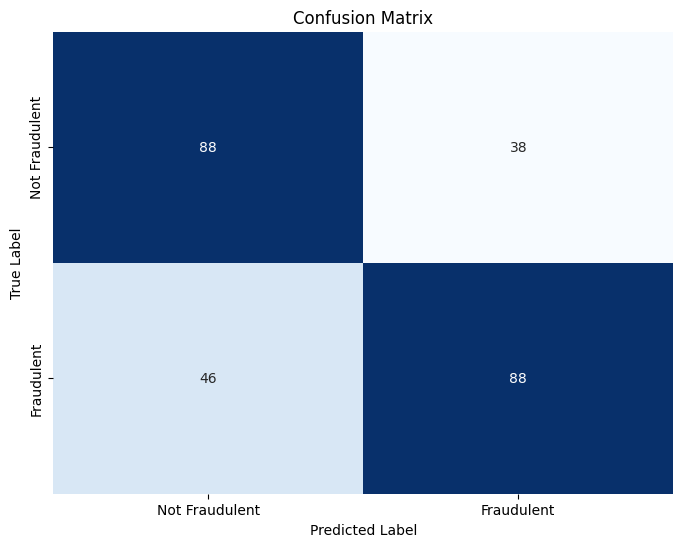

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(val_df['fraudulent'], val_preds)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraudulent', 'Fraudulent'],
            yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

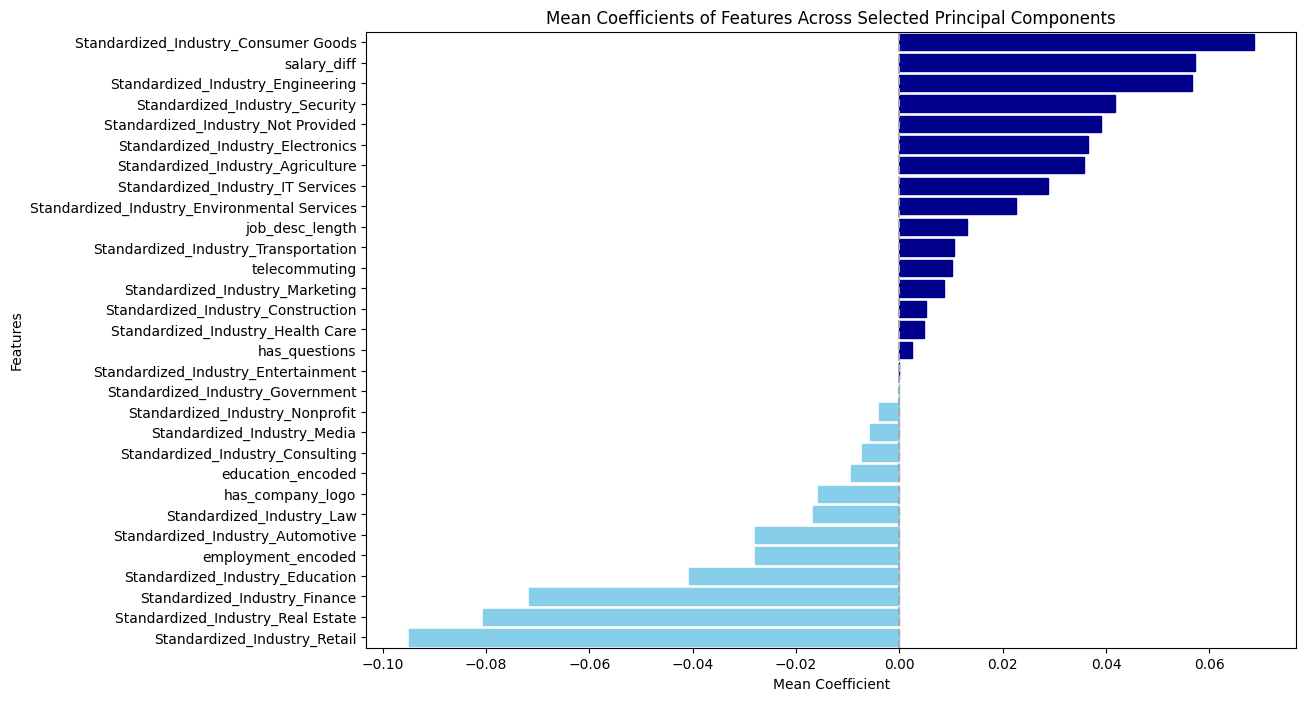

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `pca.components_` contains the PCA coefficients and `feature_columns` holds the names of features
# Flatten the coefficients for the features
coefficients = pd.DataFrame(pca.components_, columns=feature_columns)

# Create a DataFrame to hold the mean coefficients for each feature across the selected principal components
# Only use the first 23 components as per your decision
mean_coeffs = coefficients[:23].mean(axis=0).reset_index()
mean_coeffs.columns = ['Feature', 'Mean Coefficient']

# Sort the features by their mean coefficient
mean_coeffs = mean_coeffs.sort_values(by='Mean Coefficient', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
bars = sns.barplot(x='Mean Coefficient', y='Feature', data=mean_coeffs)

# Manually set bar colors (green for negative, red for positive)
for bar, coeff in zip(bars.patches, mean_coeffs['Mean Coefficient']):
    bar.set_color('skyblue' if coeff < 0 else 'darkblue')

# Titles and labels
plt.title('Mean Coefficients of Features Across Selected Principal Components')
plt.xlabel('Mean Coefficient')
plt.ylabel('Features')

# Vertical reference line at 0
plt.axvline(0, color='darkgrey', linestyle='--')

# Remove grid lines
plt.grid(False)

# Show plot
plt.show()


# Finally Testing our Model (to decent results!)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Step 1: Impute missing values in the test set
test_df_imputed = pd.DataFrame(imputer.transform(test_df[feature_columns]), columns=feature_columns)

# Step 2: Standardize the features in the test set
scaled_test_features = scaler.transform(test_df_imputed)

# Step 3: Transform the standardized test features using the PCA model
pca_test_features = pca.transform(scaled_test_features)

# Step 4: Make predictions on the PCA-transformed test set
test_preds = logr.predict(pca_test_features)

# Step 5: Calculate accuracy metrics
accuracy_test = accuracy_score(test_df['fraudulent'], test_preds)
precision_test = precision_score(test_df['fraudulent'], test_preds)
recall_test = recall_score(test_df['fraudulent'], test_preds)

# Compute confusion matrix for the test set
tn, fp, fn, tp = confusion_matrix(test_df['fraudulent'], test_preds).ravel()

# Calculate TNR, TPR, FPR, and FNR
tnr_test = tn / (tn + fp)  # True Negative Rate (Specificity)
tpr_test = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_test = fp / (fp + tn)  # False Positive Rate
fnr_test = fn / (fn + tp)  # False Negative Rate

# Display the test metrics
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"TNR: {tnr_test:.4f}")
print(f"TPR: {tpr_test:.4f}")
print(f"FPR: {fpr_test:.4f}")
print(f"FNR: {fnr_test:.4f}")


Test Accuracy: 0.7038
Test Precision: 0.7295
Test Recall: 0.6692
TNR: 0.7402
TPR: 0.6692
FPR: 0.2598
FNR: 0.3308


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


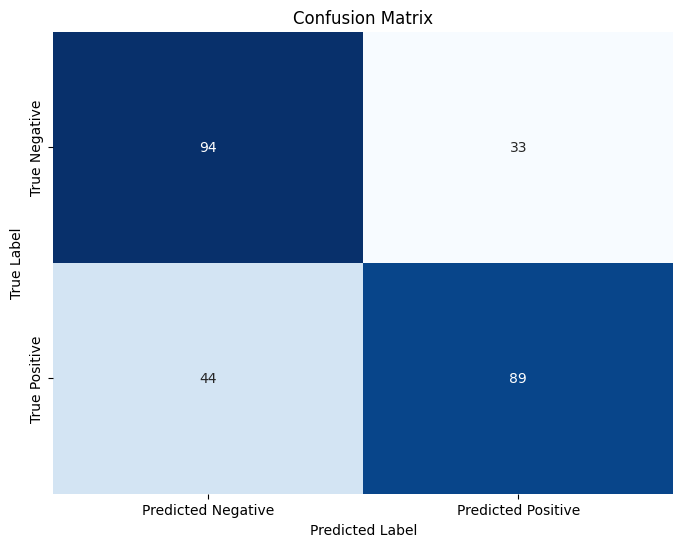

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming 'test_df' contains your test data and 'test_preds' are the predictions from your model
test_preds = logr.predict(pca_test_features)  # Replace with your model's prediction method
y_true = test_df['fraudulent']  # Replace 'fraudulent' with your actual target column name

# Compute confusion matrix
cm = confusion_matrix(y_true, test_preds)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
